In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, log_loss

In [2]:
df = pd.read_csv("/Users/jacobemerson/Code/my_projects/credit_risk_model/data/loan_data.csv")

In [3]:
df = df.rename(columns={
    "person_age": "age",
    "person_gender": "gender",
    "person_education": "education",
    "person_income": "income",
    "person_emp_exp": "emp_exp",
    "person_home_ownership": "home_ownership",
    "loan_amnt": "loan_amount",
    "loan_intent": "loan_intent",
    "loan_int_rate": "loan_rate",
    "loan_percent_income": "loan_perc_income",
    "cb_person_cred_hist_length": "credit_history",
    "credit_score": "credit_score",
    "previous_loan_defaults_on_file": "loan_defaults",
    "loan_status": "loan_status" 
})

In [4]:
df.head()

,age,gender,education,income,emp_exp,home_ownership,loan_amount,loan_intent,loan_rate,loan_perc_income,credit_history,credit_score,loan_defaults,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
#define X and y variables
target_col = "loan_status"
X = df.drop(columns=target_col)
y = df[target_col]

In [6]:
# Identify column types
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing

In [7]:
# One-hot code categorical columns only 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numerical_cols)
    ],
    remainder="drop"
)

In [8]:
# Train, test, split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Model

In [9]:
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [10]:
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", model)
])

In [11]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...), ('num', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [12]:
threshold = 0.8
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

# Model Performance Analysis

In [13]:
train_sizes, train_scores, val_scores = learning_curve(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)


In [14]:
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)

val_mean = val_scores.mean(axis=1)
val_std  = val_scores.std(axis=1)

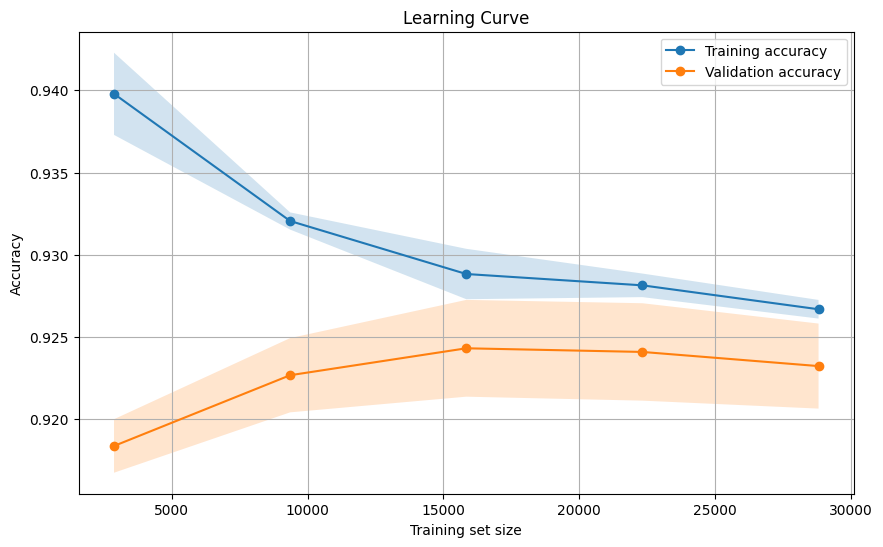

In [15]:
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, train_mean, marker="o", label="Training accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker="o", label="Validation accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_proba),
    "log_loss": log_loss(y_test, y_proba)
}

In [18]:
confusion_matrix(y_test, y_pred)

array([[6983,   17],
       [ 835, 1165]])

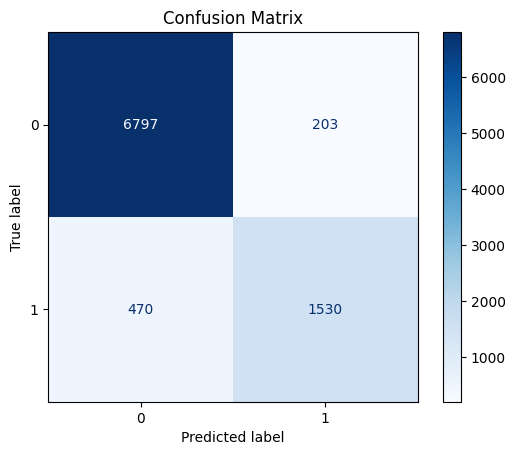

In [19]:
ConfusionMatrixDisplay.from_estimator(
    pipeline,          # or model if already fit
    X_test,
    y_test,
    cmap="Blues",
    values_format="d"  # integers
)

plt.title("Confusion Matrix")
plt.show()

In [20]:
list(zip(metrics.keys(), metrics.values()))

[('accuracy', 0.9053333333333333),
 ('precision', 0.9856175972927242),
 ('recall', 0.5825),
 ('f1', 0.7322438717787555),
 ('roc_auc', 0.9724989285714285),
 ('log_loss', 0.1706605495566614)]

# Optimization

In [ ]:
# Precision-Recall Trade Off when threshold changes

y_proba = pipeline.predict_proba(X_test)[:, 1]

threshold = 0.40
y_pred_thr = (y_proba >= threshold).astype(int)

print("Precision:", precision_score(y_test, y_pred_thr))
print("Recall:", recall_score(y_test, y_pred_thr))


Precision: 0.8243927125506073
Recall: 0.8145


In [40]:
def profit_threshold_sweep(
    pipeline,
    X_test,
    y_test,
    profit_per_good_loan,
    loss_per_default,
    thresholds=None
):
    """
    Sweep decision thresholds and compute expected profit.

    Assumes:
    - Positive class (1) = approve / good loan
    - Negative class (0) = bad loan / default

    Returns
    -------
    results : pd.DataFrame
        Threshold-level metrics and expected profit
    best : pd.Series
        Row corresponding to the profit-maximizing threshold
    """

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    # Predicted probability of approval (class 1)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    rows = []
    N = len(y_test)

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        # Confusion matrix: [[TN, FP], [FN, TP]]
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        expected_profit = tp * profit_per_good_loan - fp * loss_per_default
        approval_rate = (tp + fp) / N

        rows.append({
            "threshold": t,
            "tp": tp,
            "fp": fp,
            "tn": tn,
            "fn": fn,
            "approval_rate": approval_rate,
            "expected_profit": expected_profit
        })

    results = pd.DataFrame(rows)
    best = results.loc[results["expected_profit"].idxmax()]

    return results, best



In [39]:
results, best = profit_threshold_sweep(
    pipeline=pipeline,
    X_test=X_test,
    y_test=y_test,
    profit_per_good_loan=10000,
    loss_per_default=80000
)

print(best)

threshold          7.900000e-01
tp                 1.183000e+03
fp                 1.900000e+01
tn                 6.981000e+03
fn                 8.170000e+02
approval_rate      1.335556e-01
expected_profit    1.031000e+07
Name: 78, dtype: float64


In [27]:
best_threshold = best["threshold"]


In [36]:
def plot_expected_profit(results, best_threshold):
    """
    Plot expected profit vs threshold and mark the best threshold.

    Parameters
    ----------
    results : pd.DataFrame
        Must contain columns ['threshold', 'expected_profit']
    best_threshold : float
        Threshold that maximizes expected profit
    """

    plt.figure(figsize=(8, 5))

    plt.plot(
        results["threshold"],
        results["expected_profit"],
        label="Expected Profit"
    )

    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Best threshold = {best_threshold:.2f}"
    )

    plt.xlabel("Threshold")
    plt.ylabel("Expected Profit")
    plt.title("Expected Profit vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()



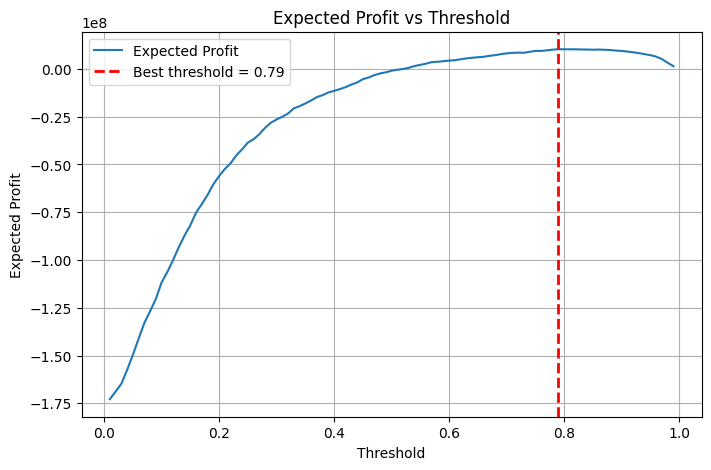

In [37]:
plot_expected_profit(results, best_threshold)
